# MFHT Grid Plot
plt.close('all')

In [3]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime
import sys
sys.path.append("..\stabilvol")
from utility import functions as f

DATABASE = '../data/processed/trapezoidal_selection/stabilvol.sqlite'
# Connect to the SQLite database
conn = sqlite3.connect(DATABASE)
cur = conn.cursor()

In [4]:
import os
print(os.getcwd())
os.path.exists(DATABASE)

G:\UNIPA\ECONOFISICA\stabilizing_volatility\notebooks


True

In [5]:
MARKETS = ["UN", "UW", "LN", "JT"]
START_DATE = "1980-01-01"
END_DATE = "2022-07-01"

T1_STRING = "m0p5"
T2_STRING = "m1p5"

START_LEVELS = [-2.0, -1.0, -0.5, -0.2, -0.1, 0.1, 0.2, 0.5, 1.0, 2.0]
DELTAS = [2.0, 1.0, 0.5, 0.2, 0.1, -0.1, -0.2, -0.5, -1.0, -2.0]
LEVELS = {
    (start, round(start+delta, 2)) for start in START_LEVELS for delta in DELTAS
}
LEVELS = sorted(LEVELS)

VOL_LIMIT= 0.5  # Change this will change all the pickle files, remember to re-generate them

In [12]:
def select_bins(df, max_n=1000):
    nbins = 25
    
    while True:
        # Use qcut to bin 'Volatility' values
        df['Bins'] = pd.qcut(df['Volatility'], nbins, duplicates='drop')
        
        # Group by the bins and calculate the mean and standard error of 'value'
        grouped = df.groupby('Bins', observed=True)['FHT'].agg(['mean', error_on_the_mean, 'size'])
        count = grouped['size'].min()
        
        if count < max_n or nbins > 1000:
            break
        else:
            nbins += 20
    return grouped, nbins

def error_on_the_mean(values):
    return np.std(values)/np.sqrt(len(values))

In [13]:
def query_binned_data(market: str, start_date:str, end_date:str = None, vol_limit:float = 0.5, t1_string:str = "m0p5", t2_string:str = "m1p5"):
    grouped_data = None
    end_date = '2023-01-01' if end_date is None else end_date
    try:            
        # Write the SQL query
        query = f'''
        SELECT *
        FROM stabilvol_{t1_string}_{t2_string}
        WHERE Volatility < {vol_limit} 
        AND Market = "{market}"
        AND start >= "{start_date}"
        AND end <= "{end_date}"    
        '''
        # Load the FHT data from the database
        df = pd.read_sql_query(query, conn)
    except pd.errors.DatabaseError:
        print(f'No data for market {market} with thresholds {t1_string}-{t2_string}')
        nbins = 0
    else:
        if len(df) > 50:
            return  select_bins(df)
        else:
            raise ValueError(f'Not enough data for market {market} with thresholds {t1_string}-{t2_string} from {start_date} to {end_date}')

## Sliding Windows
We divide the entire period into N windows and compare the stabilizing volatilites there

In [14]:
def create_windows(nwindows=20, duration=None,  start_date=None, end_date=None):
    # Define the start and end dates
    start_date = datetime.date(1980, 1, 1) if start_date is None else start_date
    end_date = datetime.date(2022, 7, 1) if end_date is None else end_date
    
    # Calculate the number of days between the start and end dates
    total_duration = (end_date - start_date).days 
    if duration is None:
        # Calculate the duration of each window in days
        window_duration = total_duration // nwindows
    else:
        window_duration = duration
        nwindows = total_duration // duration
    
    # Generate the windows
    return [(start_date + pd.to_timedelta(i * window_duration, 'D'),
            start_date + pd.to_timedelta((i + 1) * window_duration, 'D'))
           for i in range(nwindows)]

In [15]:
import matplotlib.colors as mcolors

def desaturate_color(color):
    # Convert RGB to HLS
    rgb = mcolors.to_rgb(color)
    h, s, v = mcolors.rgb_to_hsv(rgb)

    # Decrease the saturation by 50% to get a desaturated color
    return mcolors.hsv_to_rgb((h, s/4, v))


def plot_mfhts(market, mfht, ax, **kwargs):
    x = mfht.index.categories.left.values
    # Renormalize the first value
    x[0] = 0
    y = mfht['mean'].values
    
    if kwargs.get('color', False):
        line, = ax.plot(x, y, color=kwargs.get('color'), label=kwargs.get('label', None))
    else:
        line, = ax.plot(x, y, label=kwargs.get('label', None))
    
    if kwargs.get('error', True):
        y_err = mfht['error_on_the_mean'].values     
        ax.fill_between(x, y - y_err, y + y_err, color=desaturate_color(line.get_color()))

    ax.set_title(r"\emph{" + market + r"}", fontsize=18)
    
    ax.set_xlim(kwargs.get('xlim', (-0.001, 0.08)))
    
    ax.set_yscale(kwargs.get('yscale', 'linear'))
    
    ax.grid(True)
    return ax

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_inset(mfht, inset_ax):
    mfht.dropna(inplace=True)    
    x = [cat.left for cat in mfht.index.tolist()]
    y = mfht['mean'].values
    
    # Now you can plot on the inset axes
    inset_ax.plot(x, y)
    return inset_ax

In [16]:
def plot_shiftingmfht(windows, vol_limit = VOL_LIMIT, **kwargs):
    toosmallwindows = 0
    # Use LaTeX for text rendering
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharey=True, sharex=True)
    
    axs[0, 0].set_ylabel('MFHT', y=-0.1 ,fontsize=16)
    axs[1, 0].set_xlabel('Volatility', x=1.1, fontsize=16)
    
    for i, (market, ax) in enumerate(zip(MARKETS, axs.flatten())):

        for start_date, end_date in tqdm(windows, desc=market):

            try:
                mfht, nbins = query_binned_data(market, start_date, end_date, vol_limit)         
            except ValueError:
                toosmallwindows += 1
            else:
                ax = plot_mfhts(market, mfht, ax, label=start_date.strftime('%Y-%m-%d'), **kwargs)
    
    # Add common legend on top
    handles, labels = axs[0, 0].get_legend_handles_labels()  # get the handles and labels from any subplot
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)  # place the legend outside the plot area
    
    fig.tight_layout()

    plt.show()
    return toosmallwindows

JT: 100%|█████████████████████████████████████████████████| 22/22 [00:02<00:00,  9.73it/s]


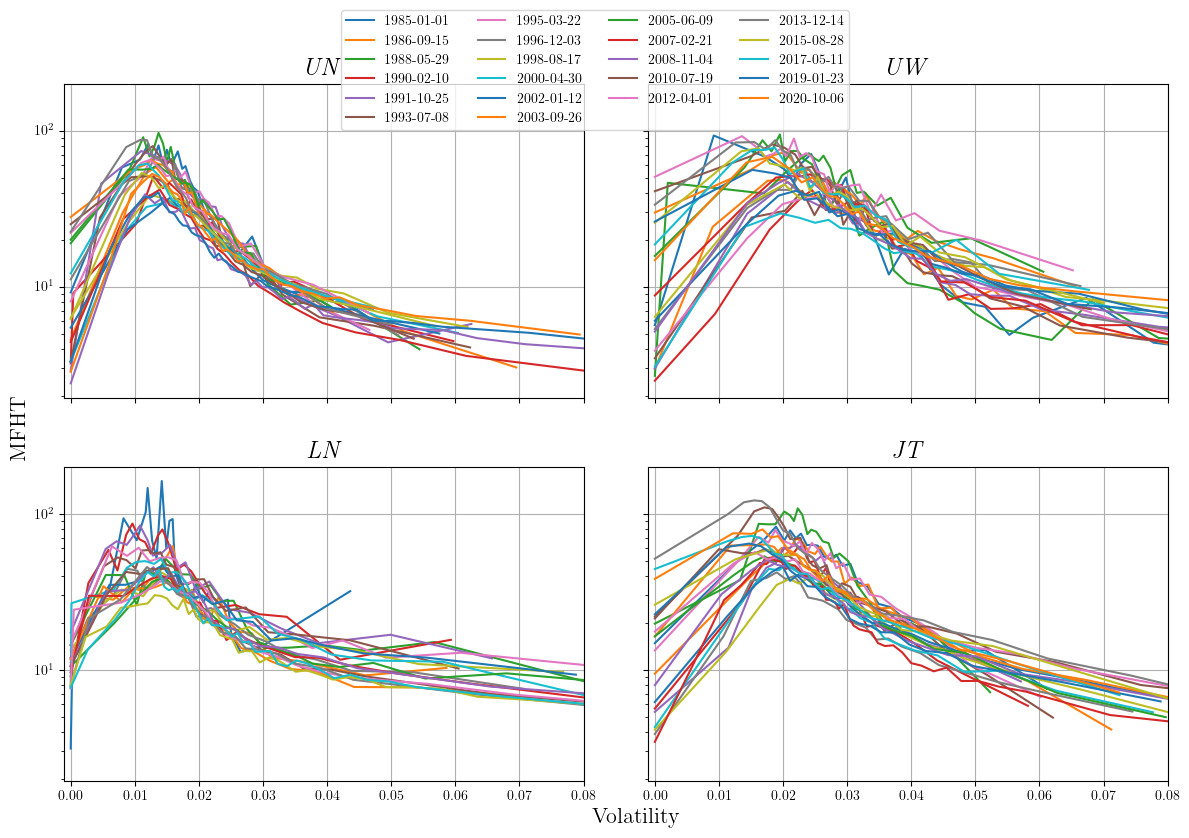

There are 2 windows with too few data points


In [17]:
windows = create_windows(22, start_date=datetime.date(1985, 1, 1))

errors = plot_shiftingmfht(windows, error=False, yscale='log')
print(f'There are {errors} windows with too few data points')

JT: 100%|█████████████████████████████████████████████████| 22/22 [00:02<00:00,  9.56it/s]


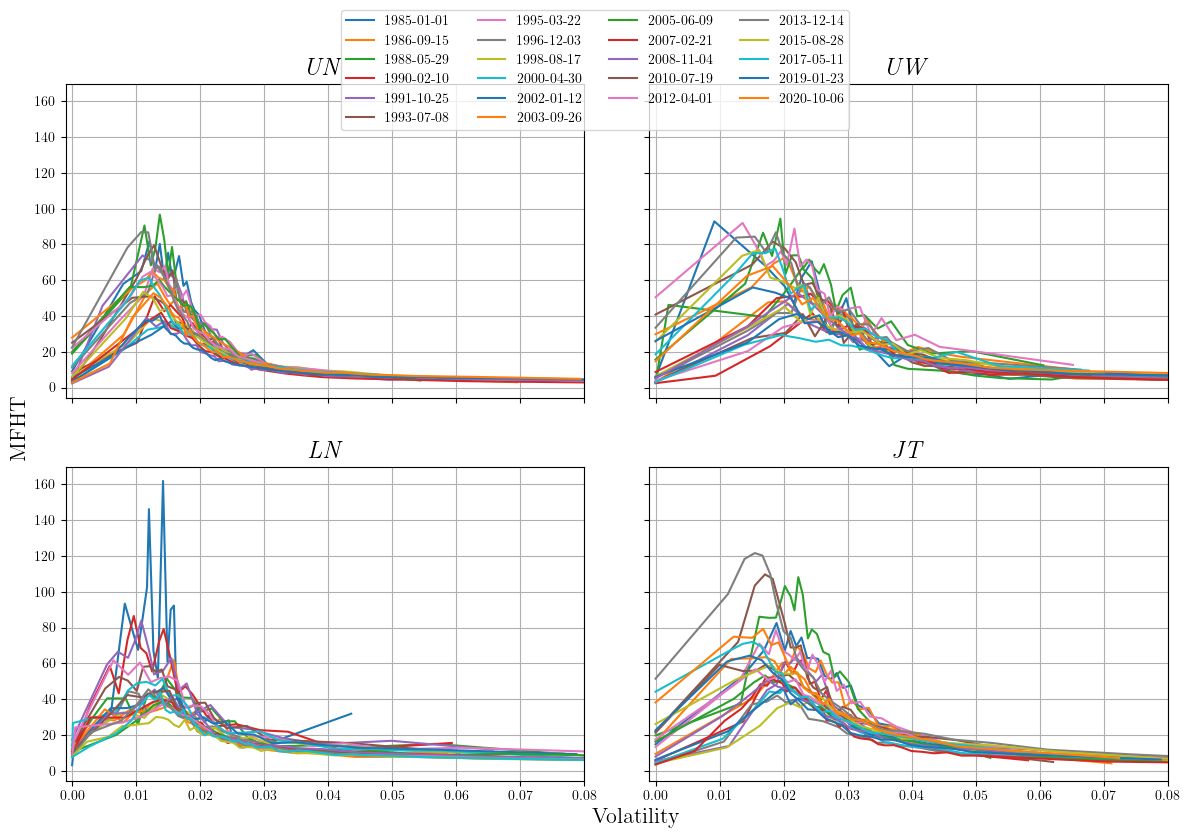

There are 2 windows with too few data points


In [18]:
errors = plot_shiftingmfht(windows, error=False, yscale='linear')
print(f'There are {errors} windows with too few data points')

## Highlight the 2008-crisis 

In [ ]:
def plot_shiftingmfht_crisis(windows, vol_limit = VOL_LIMIT, **kwargs):
    toosmallwindows = 0
    # Use LaTeX for text rendering
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharey=True, sharex=True)
    
    axs[0, 0].set_ylabel('MFHT', y=-0.1 ,fontsize=16)
    axs[1, 0].set_xlabel('Volatility', x=1.1, fontsize=16)
    
    for i, (market, ax) in enumerate(zip(MARKETS, axs.flatten())):

        for start_date, end_date in tqdm(windows, desc=market):

            try:
                mfht, nbins = query_binned_data(market, start_date, end_date, vol_limit)         
            except ValueError:
                toosmallwindows += 1
            else:
                if start_date > datetime.date(2007, 1, 1) and end_date < datetime.date(2009, 1, 1):
                    x = mfht.index.categories.left.values
                    # Renormalize the first value
                    x[0] = 0
                    y = mfht['mean'].values
                    
                    ax.plot(x, y, label=start_date.strftime('%Y-%m-%d'), zorder=10, linewidth=2)
                else:
                    ax = plot_mfhts(market, mfht, ax, color='lightblue', **kwargs)
    
    # Add common legend on top
    handles, labels = axs[0, 0].get_legend_handles_labels()  # get the handles and labels from any subplot
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)  # place the legend outside the plot area
    
    fig.tight_layout()

    plt.show()
    return toosmallwindows

In [ ]:
windows = create_windows(duration=365//4, start_date=datetime.date(1990, 1, 1))
plot_shiftingmfht_crisis(windows, error=False, yscale='log')

## Heatmap Plots of the Sliding Windows

In [19]:
def create_dataset(windows):
    outcasts = {market: [] for market in MARKETS}
    df = pd.DataFrame()
    for market in MARKETS:
        for start_date, end_date in tqdm(windows, desc=market):
            try:
                mfht, nbins = query_binned_data(market, start_date, end_date, VOL_LIMIT, t1_string=T1_STRING, t2_string=T2_STRING)         
            except ValueError:
                outcasts[market].append((start_date, end_date))
            else:
                mfht['start'] = start_date
                mfht['end'] = end_date
                mfht['market'] = market
                df = pd.concat([df, mfht.reset_index()])
                
    return df, outcasts

In [20]:
from matplotlib.patches import ConnectionPatch
def add_ticks(ax, market, labels, outcasts, highlights=True):
    ax.set_xticks(np.arange(0.5, len(windows), 1)[::4], minor=False, labels=labels[::4], fontsize=11, rotation=90, ha='right', rotation_mode='anchor')
    ax.set_ylabel(market, fontsize=16)
    # Remove xticks
    ax.yaxis.set_ticks([])
    
    # Convert labels to Timestamps
    label_dates = pd.to_datetime(labels)
    outcast_dates = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in outcasts]
    for outcast in outcast_dates:
        # Find the indices of the start and end labels
        start_index = np.where(label_dates <= outcast[0])
        # Since only the end date is labeled, if the first start date is an outcast, it must be set manually
        start_index = start_index[0][-1] if len(start_index[0]) > 0 else 0
        end_index = np.where(label_dates >= outcast[1])[0][0]
        ax.axvspan(start_index-0.5, end_index-0.5, color='black')
    
    if highlights:
        # Find the indices of the start and end labels
        start_index = np.where(label_dates < pd.to_datetime('2007-01-01'))[0][-1]
        end_index = np.where(label_dates > pd.to_datetime('2009-01-01'))[0][0]
    
        # Add vertical lines at the start and end of the region
        ax.axvline(start_index-0.5, color='k', linestyle='--', linewidth=1.5)
        ax.axvline(end_index-0.5, color='k', linestyle='--', linewidth=1.5)


def plot_shiftingmfht_heatmap(data, windows, maxs=None, outcasts=None, **kwargs):
    toosmallwindows = 0
    outcasts = {market: [] for market in MARKETS} if maxs is None else outcasts
    if kwargs.get('latex', False):    
        # Use LaTeX for text rendering
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = 'serif'
    
    fig, axs = plt.subplots(4, figsize=(12, 4), sharex=True)
    
    max_values = np.zeros((len(MARKETS), len(windows))) if maxs is None else maxs
    

    for i, (market, ax) in enumerate(zip(MARKETS, axs.flatten())):
        if maxs is None:
            # Calculate the peaks
            for j, (start_date, end_date) in enumerate(windows):
                mfht = data[(data['market'] == market) & (data['start'] == start_date) & (data['end'] == end_date)]       
                if mfht.empty:            
                    outcasts[market].append((start_date, end_date))
                else:
                    max_values[i, j] = mfht['mean'].max()

        im = ax.imshow(max_values[i].reshape(1, -1), cmap='coolwarm', aspect='auto', vmin=max_values[i].min(), vmax=max_values[i].max())
         # Show ticks four by four and label them with the respective list entries
        labels = [end_date.strftime('%Y-%m-%d') for start_date, end_date in windows]
        add_ticks(ax, market, labels, outcasts[market])
    
    axs[0].text(0.47, 1.1, '2007-01-01', fontsize=11, transform=axs[0].transAxes, horizontalalignment='left')
    axs[0].text(0.63, 1.1, '2009-01-01', fontsize=11, transform=axs[0].transAxes, horizontalalignment='right')
    
    fig.tight_layout()

    # Add a colorbar
    cbar = fig.colorbar(im, ax=axs.ravel().tolist(), pad=0.01)
    cbar.set_label('Maximum MFHT', rotation=270, labelpad=15)

    plt.show()
    return fig, toosmallwindows

In [21]:
windows = create_windows(duration=90, start_date=datetime.date(1990, 1, 1))
len(windows)

131

In [22]:
df, outcasts = create_dataset(windows)

JT: 100%|███████████████████████████████████████████████| 131/131 [00:11<00:00, 11.65it/s]


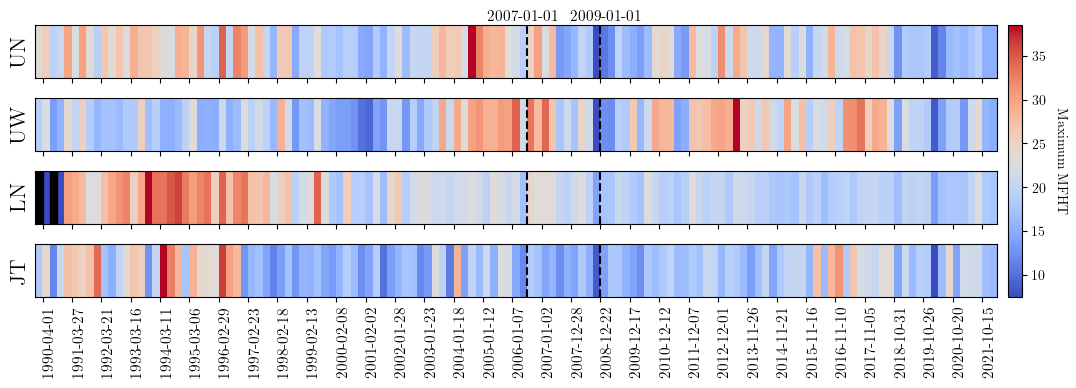

In [23]:
fig, errors = plot_shiftingmfht_heatmap(df, windows, latex=True)

In [24]:
fig.savefig(f'../visualization/dynamics/shifting_windows/shifting_MFHT_peaks.png', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/shifting_windows/shifting_MFHT_peaks.eps', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/shifting_windows/shifting_MFHT_peaks.pdf', bbox_inches='tight')

## Rolling Windows

In [25]:
def roll_windows(duration=90,  start_date=None, end_date=None):
    # Define the start and end dates
    start_date = datetime.date(1980, 1, 1) if start_date is None else start_date
    end_date = datetime.date(2022, 7, 1) if end_date is None else end_date
    
    start = start_date + pd.to_timedelta(duration/2, 'D')
    end = end_date - pd.to_timedelta(duration/2, 'D')
    return [(mid - pd.to_timedelta(duration//2, 'D'), mid + pd.to_timedelta(duration//2, 'D')) for mid in pd.date_range(start, end, freq='D')]

In [26]:
windows = roll_windows(90, start_date=datetime.date(2000, 1, 1), end_date=datetime.date(2010, 1, 1))
len(windows)

3564

In [27]:
df, outcasts = create_dataset(windows)
print(f"There are {len(outcasts)} outcasts")
outcasts

JT: 100%|█████████████████████████████████████████████| 3564/3564 [05:27<00:00, 10.87it/s]

There are 4 outcasts


{'UN': [],
 'UW': [(Timestamp('2005-12-23 00:00:00'), Timestamp('2006-03-23 00:00:00')),
  (Timestamp('2005-12-24 00:00:00'), Timestamp('2006-03-24 00:00:00')),
  (Timestamp('2005-12-25 00:00:00'), Timestamp('2006-03-25 00:00:00')),
  (Timestamp('2005-12-26 00:00:00'), Timestamp('2006-03-26 00:00:00')),
  (Timestamp('2005-12-27 00:00:00'), Timestamp('2006-03-27 00:00:00')),
  (Timestamp('2006-11-03 00:00:00'), Timestamp('2007-02-01 00:00:00')),
  (Timestamp('2006-11-04 00:00:00'), Timestamp('2007-02-02 00:00:00')),
  (Timestamp('2006-11-05 00:00:00'), Timestamp('2007-02-03 00:00:00')),
  (Timestamp('2006-11-06 00:00:00'), Timestamp('2007-02-04 00:00:00')),
  (Timestamp('2006-11-07 00:00:00'), Timestamp('2007-02-05 00:00:00')),
  (Timestamp('2006-11-08 00:00:00'), Timestamp('2007-02-06 00:00:00')),
  (Timestamp('2006-11-09 00:00:00'), Timestamp('2007-02-07 00:00:00')),
  (Timestamp('2006-11-10 00:00:00'), Timestamp('2007-02-08 00:00:00')),
  (Timestamp('2006-11-11 00:00:00'), Timestamp(

It may be better to first save peaks data and then plot them

In [28]:
data = df.copy()
max_values = np.zeros((len(MARKETS), len(windows)))
for i, market in enumerate(MARKETS):
        for j, (start_date, end_date) in tqdm(enumerate(windows), desc=market):

            mfht = data[(data['market'] == market) & (data['start'] == start_date) & (data['end'] == end_date)]       
            if not mfht.empty:            
                max_values[i, j] = mfht['mean'].max()
                
np.save(f'../data/processed/dynamics/rolling_MFHT_peaks_{T1_STRING}_{T2_STRING}_{VOL_LIMIT}.npy', max_values)

UN: 3564it [00:53, 67.13it/s]
UW: 3564it [00:53, 66.27it/s]
LN: 3564it [00:51, 69.06it/s]
JT: 3564it [00:51, 68.73it/s]


In [ ]:
def add_ticks(ax, market, labels, outcasts, highlights=True):
    ax.set_xticks(np.arange(0.5, len(windows), 1)[::90], minor=False, labels=labels[::90], fontsize=11, rotation=90, ha='right', rotation_mode='anchor')
    ax.set_ylabel(market, fontsize=16)
    # Remove xticks
    ax.yaxis.set_ticks([])
    
    # Convert labels to Timestamps
    label_dates = pd.to_datetime(labels)
    outcast_dates = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in outcasts]
    for outcast in outcast_dates:
        # Find the indices of the start and end labels
        start_index = np.where(label_dates <= outcast[0])
        # Since only the end date is labeled, if the first start date is an outcast, it must be set manually
        start_index = start_index[0][-1] if len(start_index[0]) > 0 else 0
        end_index = np.where(label_dates >= outcast[1])[0][0]
        ax.axvspan(start_index-0.5, end_index-0.5, color='black')
    
    if highlights:
        # Find the indices of the start and end labels
        start_index = np.where(label_dates < pd.to_datetime('2007-01-01'))[0][-1]
        end_index = np.where(label_dates > pd.to_datetime('2009-01-01'))[0][0]
    
        # Add vertical lines at the start and end of the region
        ax.axvline(start_index-0.5, color='k', linestyle='--', linewidth=1.5)
        ax.axvline(end_index-0.5, color='k', linestyle='--', linewidth=1.5)


def plot_rolling_heatmap(data, windows, maxs=None, outcasts=None, **kwargs):
    toosmallwindows = 0
    outcasts = {market: [] for market in MARKETS} if maxs is None else outcasts
    if kwargs.get('latex', False):    
        # Use LaTeX for text rendering
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = 'serif'
    
    fig, axs = plt.subplots(4, figsize=(12, 4), sharex=True)
    
    max_values = np.zeros((len(MARKETS), len(windows))) if maxs is None else maxs
    

    for i, (market, ax) in enumerate(zip(MARKETS, axs.flatten())):
        if maxs is None:
            # Calculate the peaks
            for j, (start_date, end_date) in enumerate(windows):
                mfht = data[(data['market'] == market) & (data['start'] == start_date) & (data['end'] == end_date)]       
                if mfht.empty:            
                    outcasts[market].append((start_date, end_date))
                else:
                    max_values[i, j] = mfht['mean'].max()

        im = ax.imshow(max_values[i].reshape(1, -1), cmap='coolwarm', aspect='auto', vmin=max_values[i].min(), vmax=max_values[i].max())
         # Show ticks four by four and label them with the respective list entries
        labels = [end_date.strftime('%Y-%m-%d') for start_date, end_date in windows]
        add_ticks(ax, market, labels, outcasts[market])
    
    axs[0].text(0.66, 1.1, '2007-01-01', fontsize=11, transform=axs[0].transAxes, horizontalalignment='left')
    axs[0].text(0.92, 1.1, '2009-01-01', fontsize=11, transform=axs[0].transAxes, horizontalalignment='right')
    
    fig.tight_layout()

    # Add a colorbar
    cbar = fig.colorbar(im, ax=axs.ravel().tolist(), pad=0.01)
    cbar.set_label('Maximum MFHT', rotation=270, labelpad=15)

    plt.show()
    return fig, toosmallwindows

In [ ]:
fig, errors = plot_rolling_heatmap(df, windows, max_values, outcasts, latex=True)

In [ ]:
fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_MFHT_peaks.png', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_MFHT_peaks.eps', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_MFHT_peaks.pdf', bbox_inches='tight')